In [ ]:
import os
import io
from google.colab import drive, auth
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload

# Mount google drive
DRIVE = '/content/gdrive'
drive.mount(DRIVE)

# create folder to write data to
CIS680_FOLDER = os.path.join(DRIVE, 'My Drive', 'Colab Notebooks', 'CIS 680')
HOMEWORK_FOLDER = os.path.join(CIS680_FOLDER, 'Final Project')
os.makedirs(HOMEWORK_FOLDER, exist_ok=True)

Mounted at /content/gdrive


# Data Preparation

tensor([[ 20.0000, -17.0000,  45.0000,  -3.1413],
        [  6.5000,  -3.5000,  44.0000,   0.1366],
        [ 23.5000, -13.5000,  45.0000,  -0.1366],
        [  5.5000,   3.0000,  43.5000,   3.0557],
        [ 11.0000,  -7.5000,  45.0000,   0.0000],
        [  7.0000,  -4.0000,  44.0000,   0.1366],
        [ 12.0000,  -8.5000,  45.0000,  -0.1366],
        [ 15.5000, -12.0000,  45.0000,  -0.5716]])
torch.Size([8, 3, 360, 640])


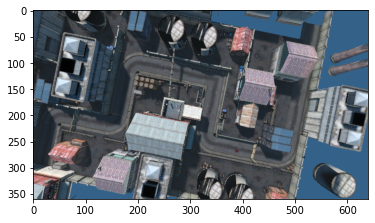

tensor([[ 21.5000, -18.0000,  45.0000,  -3.1413],
        [ 20.5000, -13.0000,  45.0000,  -0.5716],
        [ 24.0000, -14.0000,  45.0000,  -0.1366],
        [  4.0000,  -2.5000,  44.0000,   0.9181],
        [ 14.5000, -11.0000,  45.0000,  -0.5716],
        [ 18.5000, -16.5000,  45.0000,  -3.1413],
        [ 22.0000, -18.5000,  45.0000,  -3.1413],
        [  4.0000,   3.0000,  43.5000,   3.0557]])
torch.Size([8, 3, 360, 640])


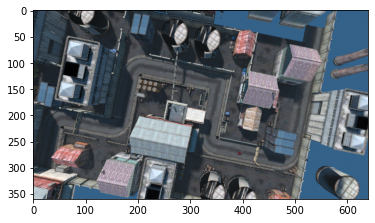

tensor([[ 17.5000, -15.0000,  45.0000,  -2.8303],
        [ 21.5000, -12.5000,  45.0000,  -0.5716],
        [  2.5000,  -1.0000,  43.5000,   1.1299],
        [ 22.5000, -19.0000,  45.0000,  -3.1413],
        [ 13.0000,  -9.5000,  45.0000,  -0.2757],
        [  0.5000,   1.0000,  43.5000,   3.1413],
        [ 19.5000, -16.0000,  45.0000,  -2.8303],
        [ 24.5000, -14.5000,  45.0000,   0.0000]])
torch.Size([8, 3, 360, 640])


In [ ]:
import torch
from math import pi
import numpy as np
from PIL import Image
import torchvision
import matplotlib.pyplot as plt


class KittiDataset(torch.utils.data.Dataset):
    def __init__(self, path):
        # setup directories for no rotation dataset
        # self.image_dir = os.path.join(path, 'data', '4Pose_NoRot')
        # self.labels = torch.Tensor(np.load(os.path.join(path, 'data', '4Pose_NoRot.npy')))

        # setup directories for rotation dataset
        self.image_dir = os.path.join(path, 'data', '4Pose_Rot')
        self.labels = torch.Tensor(np.load(os.path.join(path, 'data', '4Pose_Rot.npy')))

        self.num_images = 100 #len(os.listdir(self.image_dir))
        
        # cache images
        self.images = []
        transform = torchvision.transforms.ToTensor()
        for i in range(self.num_images):
            img = Image.open(os.path.join(self.image_dir, 'img' + str(i + 1) + '.png')) 
            self.images.append(transform(img))
        self.images = torch.stack(self.images)

    def __len__(self):
        return self.num_images

    def __getitem__(self, idx):
        normalized_img = (self.images[idx] - self.images[idx].min()) / \
                         (self.images[idx].max() - self.images[idx].min())
        target = self.labels[idx]
        radians = torch.exp(target[-1]) / (torch.exp(target[-1]) + 1) * 2 * pi - pi
        target[-1] = radians
        return normalized_img, target


class KittiDataLoader(torch.utils.data.DataLoader):
    def __init__(self, dataset, batch_size, shuffle, num_workers):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_workers = num_workers

    def collect_fn(self, batch):
        transed_img_list = []
        target_list = []
        for transed_img, target in batch:
            transed_img_list.append(transed_img)
            target_list.append(target)
        return torch.stack(transed_img_list, dim=0), torch.stack(target_list)

    def loader(self):
        return torch.utils.data.DataLoader(self.dataset,
                                           batch_size=self.batch_size,
                                           shuffle=self.shuffle,
                                           num_workers=self.num_workers,
                                           collate_fn=self.collect_fn)


batch_size = 8
train_dataset = KittiDataset(HOMEWORK_FOLDER)
train_dataloader = KittiDataLoader(train_dataset,
                                    batch_size=batch_size,
                                    shuffle=True,
                                    num_workers=0)
train_loader = train_dataloader.loader()

# number of visualizations to show
num_images = 2

# loop through minibatches
for i, batch in enumerate(train_loader, 0):
    img, target = batch
    # print(target)
    # print(img.shape)
    if i == num_images:
        break
    plt.imshow(img[0].squeeze().numpy().transpose(1, 2, 0))
    plt.show()




# Model Definition

In [ ]:
import torchvision.models as models

# Candidate backbone architectures
squeezenet = models.squeezenet1_0()
shufflenet = models.shufflenet_v2_x1_0()
mobilenet = models.mobilenet_v2()
mnasnet = models.mnasnet1_0()

def get_network_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

for i, batch in enumerate(train_loader, 0):
    for backbone in [squeezenet, shufflenet, mobilenet, mnasnet]:
        x = backbone(batch[0])
        # print(get_network_params(backbone))
    break

1248424
2278604
3504872
4383312


In [ ]:
import torch.nn as nn

class PoseEstimatorModel(nn.Module):
    def __init__(self, backbone, device):
        super(PoseEstimatorModel, self).__init__()
        self.device = device
        self.backbone = backbone
        self.linear = nn.Linear(1000, 4)
        self.cartesian_criterion = nn.MSELoss()

    def forward(self, x):
        x = self.backbone(x)
        x = self.linear(x)
        return x

    def cartesian_loss(self, output, target):
        return self.cartesian_criterion(output[:, :-1], target[:, :-1])

    def angle_loss(self, output, target):
        return torch.mean(torch.abs(torch.cos(output[:, -1] - target[:, -1]) - 1))
     
    def visualize(self, img, output, target):
        output = output[0].cpu().detach().numpy()
        target = target[0].cpu().detach().numpy()
        plt.imshow(img[0].cpu().squeeze().numpy().transpose(1, 2, 0))
        plt.scatter(output[0] / output[2], output[1] / output[2], marker='o', c='g')
        plt.scatter(target[0] / target[2], target[1] / output[2], marker='o', c='r')
        plt.show()


# Training Loop

Epoch 1/10 Training
	Iter 1/13	cartesian loss:  1104.1676	angle loss:  171.0958	total loss:  1275.2634


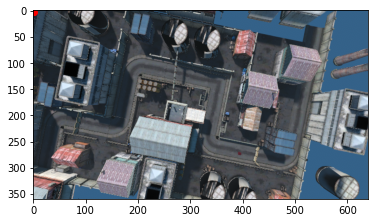

Epoch 2/10 Training
	Iter 1/13	cartesian loss:  415.4975	angle loss:  30.1998	total loss:  445.6973


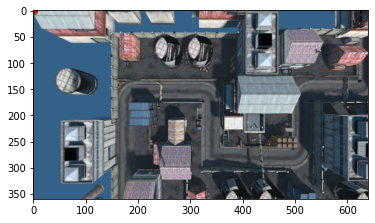

Epoch 3/10 Training
	Iter 1/13	cartesian loss:  70.6996	angle loss:  12.4681	total loss:  83.1677


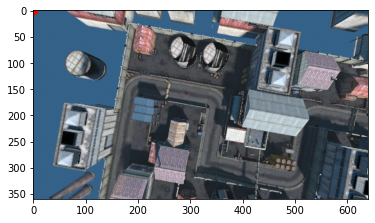

Epoch 4/10 Training
	Iter 1/13	cartesian loss:  36.1992	angle loss:  30.2532	total loss:  66.4524


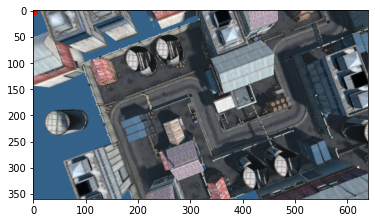

Epoch 5/10 Training
	Iter 1/13	cartesian loss:  38.3685	angle loss:  29.3861	total loss:  67.7546


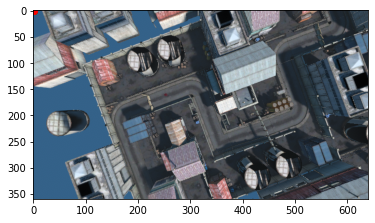

Epoch 6/10 Training
	Iter 1/13	cartesian loss:  68.1685	angle loss:  37.3734	total loss:  105.542


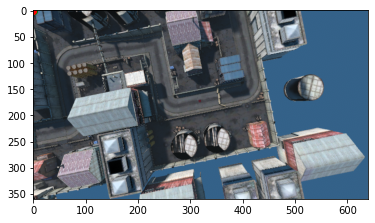

Epoch 7/10 Training
	Iter 1/13	cartesian loss:  28.9435	angle loss:  18.0473	total loss:  46.9908


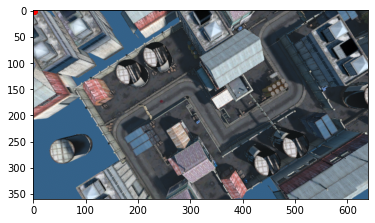

Epoch 8/10 Training
	Iter 1/13	cartesian loss:  34.6476	angle loss:  34.2097	total loss:  68.8573


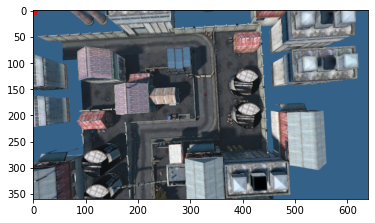

Epoch 9/10 Training
	Iter 1/13	cartesian loss:  73.8254	angle loss:  52.8266	total loss:  126.652


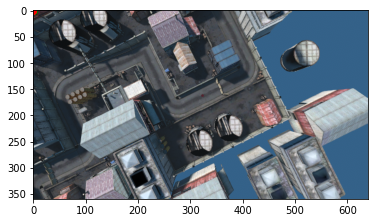

Epoch 10/10 Training
	Iter 1/13	cartesian loss:  45.9565	angle loss:  30.1932	total loss:  76.1496


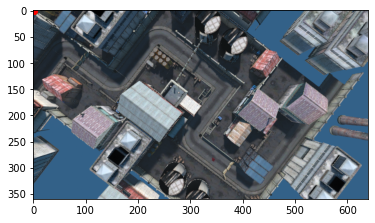

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate network
network = PoseEstimatorModel(squeezenet, device).to(device)

# Define learning parameters
learning_rate = 5e-5
log_interval = 25
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
num_epochs = 10
epsilon = 100

# Initialize data structures
total = []
total_angle_loss = []
total_cartesian_loss = []

# Run the epoch
for epoch in range(0, num_epochs):
    losses = []
    angle_losses = []
    cartesian_losses = []

    # training loop
    print("Epoch %d/%d Training" % (epoch + 1, num_epochs))
    for iter, batch in enumerate(train_loader, 0):
        # extract batch data and load to cuda
        img, target = batch
        img = img.cuda()
        target = target.cuda()

        # zero optimizer
        optimizer.zero_grad()

        # feed through Box Head
        output = network(img)

        # compute loss
        cartesian_loss = network.cartesian_loss(output, target)
        angle_loss = epsilon * network.angle_loss(output, target)
        loss = angle_loss + cartesian_loss
        loss.backward()
        optimizer.step()

        # logging
        losses.append(loss.item())
        cartesian_losses.append(cartesian_loss.item())
        angle_losses.append(angle_loss.item())
        if iter % log_interval == 0:
            print("\tIter %d/%d" % (iter+1, len(train_loader)), end='')
            total_angle_loss.append(sum(cartesian_losses) / len(cartesian_losses))
            print("\tcartesian loss: ", round(total_angle_loss[-1], 4), end='')
            total_cartesian_loss.append(sum(angle_losses) / len(angle_losses))
            print("\tangle loss: ", round(total_cartesian_loss[-1], 4), end='')
            total.append(sum(losses) / len(losses))
            print("\ttotal loss: ", round(total[-1], 4))
            #network.visualize(img, output, target)

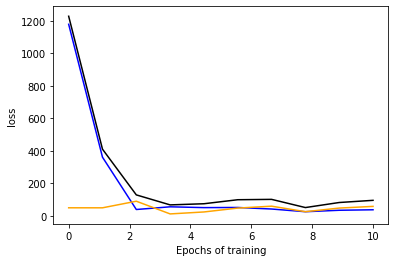

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(np.linspace(0, num_epochs, num=len(total)), total, color='black')
plt.plot(np.linspace(0, num_epochs, num=len(total)), total_angle_loss, color='blue')
plt.plot(np.linspace(0, num_epochs, num=len(total)), total_cartesian_loss, color='orange')
plt.xlabel('Epochs of training')
plt.ylabel('loss')
plt.show()
